# The Endogenous Grid Method

## Contents

- [The Endogenous Grid Method](#The-Endogenous-Grid-Method)  
  - [Overview](#Overview)  
  - [Key Idea](#Key-Idea)  
  - [Implementation](#Implementation)  
  - [Speed](#Speed)  

## Overview

We solved the stochastic optimal growth model using

1. [value function iteration](https://lectures.quantecon.org/py/optgrowth.html)  
1. [Coleman policy function iteration](https://lectures.quantecon.org/py/coleman_policy_iter.html)  


We found Coleman policy function iteration to be significantly more accurate at each step

In this lecture we'll look at an ingenious twist on Coleman policy function iteration called the **endogenous grid method** (EGM)

EGM is a numerical method for implementing policy iteration invented by [Chris Carroll](http://www.econ2.jhu.edu/people/ccarroll/)

It is a good example of how a clever algorithm can save a massive amount of computer time

(Massive when we multiply saved CPU cycles on each implementation times the number of implementations worldwide)

The original reference is [[Car06]](https://lectures.quantecon.org/py/zreferences.html#carroll2006)

## Key Idea

Let's start by reminding ourselves of the theory and then see how the numerics fit in

### Theory

Take the model set out in [the Coleman policy iteration lecture](https://lectures.quantecon.org/py/coleman_policy_iter.html), following the same terminology and notation

The Euler equation is

$$
(u'\circ c^*)(y)
= \beta \int (u'\circ c^*)(f(y - c^*(y)) z) f'(y - c^*(y)) z \phi(dz)
$$

As we saw, the Coleman operator is a nonlinear operator $ K $ engineered so that $ c^* $ is a fixed point of $ K $

It takes as its argument a continuous strictly increasing consumption policy $ g \in \Sigma $

It returns a new function $ Kg $,  where $ (Kg)(y) $ is the $ c \in (0, \infty) $ that solves


<a id='equation-egm_coledef'></a>
$$
u'(c)
= \beta \int (u' \circ g) (f(y - c) z ) f'(y - c) z \phi(dz)
\qquad \qquad (\star)
$$

### Exogenous Grid

As discussed in [the lecture](https://lectures.quantecon.org/py/coleman_policy_iter.html) on Coleman policy iteration, to implement the method on a computer we need numerical approximation

In particular, we represent a policy function by a set of values on a finite grid

The function itself is reconstructed from this representation when necessary, using interpolation or some other method

[Previously](https://lectures.quantecon.org/py/coleman_policy_iter.html), to obtain a finite represention of an updated consumption policy we

- fixed a grid of income points $ \{y_i\} $  
- calculated the consumption value $ c_i $ corresponding to each
  $ y_i $ using $(\star)$ and a root finding routine  


Each $ c_i $ is then interpreted as the value of the function $ K g $ at $ y_i $

Thus, with the points $ \{y_i, c_i\} $ in hand, we can reconstruct $ Kg $ via approximation

Iteration then continues...

### Endogenous Grid

The method discussed above requires a root finding routine to find the
$ c_i $ corresponding to a given income value $ y_i $

As pointed out by Carroll [[Car06]](https://lectures.quantecon.org/py/zreferences.html#carroll2006), we can avoid this if
$ y_i $ is chosen endogenously

The only assumption required is that $ u' $ is invertible on $ (0, \infty) $

The idea is this:

First we fix an *exogenous* grid $ \{k_i\} $ for capital ($ k = y - c $)

Then we obtain  $ c_i $ via


$$
c_i =
(u')^{-1}
\left\{
    \beta \int (u' \circ g) (f(k_i) z ) \, f'(k_i) \, z \, \phi(dz)
\right\}
$$

where $ (u')^{-1} $ is the inverse function of $ u' $

Finally, for each $ c_i $ we set $ y_i = c_i + k_i $

The key observation is that each $ (y_i, c_i) $ pair constructed in this
manner satisfies $(\star)$

You can see this just by comparing $(\star)$ and the equation for $c_i$,
combined with the identity $ y_i = c_i + k_i $

The name EGM comes from the fact that the grid $ \{y_i\} $ is  determined **endogenously**

With the points $ \{y_i, c_i\} $ in hand, we can reconstruct $ Kg $ via approximation as before

## Implementation

Let's implement this version of the Coleman operator and see how it performs

### The Operator

Here's an implementation of $ K $ using EGM as described above

In [1]:
import numpy as np

def coleman_egm(g, k_grid, beta, u_prime, u_prime_inv, f, f_prime, shocks):
    """
    The approximate Coleman operator, updated using the endogenous grid
    method.  
    
    Parameters
    ----------
    g : function
        The current guess of the policy function
    k_grid : array_like(float, ndim=1)
        The set of *exogenous* grid points, for capital k = y - c
    beta : scalar
        The discount factor
    u_prime : function
        The derivative u'(c) of the utility function
    u_prime_inv : function
        The inverse of u' (which exists by assumption)
    f : function
        The production function f(k)
    f_prime : function
        The derivative f'(k)
    shocks : numpy array
        An array of draws from the shock, for Monte Carlo integration (to
        compute expectations).

    """

    # Allocate memory for value of consumption on endogenous grid points
    c = np.empty_like(k_grid)  

    # Solve for updated consumption value
    for i, k in enumerate(k_grid):
        vals = u_prime(g(f(k) * shocks)) * f_prime(k) * shocks
        c[i] = u_prime_inv(beta * np.mean(vals))
    
    # Determine endogenous grid
    y = k_grid + c  # y_i = k_i + c_i

    # Update policy function and return
    Kg = lambda x: np.interp(x, y, c)
    return Kg

Note the lack of any root finding algorithm

Compare it with our [original implementation](https://lectures.quantecon.org/py/coleman_policy_iter.html), which uses an exogenous grid and requires root finding:

In [2]:
def coleman_operator(g, grid, beta, u_prime, f, f_prime, shocks, Kg=None):
    """
    The approximate Coleman operator, which takes an existing guess g of the
    optimal consumption policy and computes and returns the updated function
    Kg on the grid points.  An array to store the new set of values Kg is
    optionally supplied (to avoid having to allocate new arrays at each
    iteration).  If supplied, any existing data in Kg will be overwritten.

    Parameters
    ----------
    g : array_like(float, ndim=1)
        The value of the input policy function on grid points
    grid : array_like(float, ndim=1)
        The set of grid points
    beta : scalar
        The discount factor
    u_prime : function
        The derivative u'(c) of the utility function
    f : function
        The production function f(k)
    f_prime : function
        The derivative f'(k)
    shocks : numpy array
        An array of draws from the shock, for Monte Carlo integration (to
        compute expectations).
    Kg : array_like(float, ndim=1) optional (default=None)
        Array to write output values to

    """
    # === Apply linear interpolation to g === #
    g_func = lambda x: np.interp(x, grid, g)

    # == Initialize Kg if necessary == #
    if Kg is None:
        Kg = np.empty_like(g)

    # == solve for updated consumption value
    for i, y in enumerate(grid):
        def h(c):
            vals = u_prime(g_func(f(y - c) * shocks)) * f_prime(y - c) * shocks
            return u_prime(c) - beta * np.mean(vals)
        c_star = brentq(h, 1e-10, y - 1e-10)
        Kg[i] = c_star

    return Kg

Below we test out the code above on some example parameterizations, after the following imports

In [3]:
import matplotlib.pyplot as plt
import quantecon as qe

### Testing on the Log / Cobb--Douglas case

As we [did for value function iteration](https://lectures.quantecon.org/py/optgrowth.html)
and [Coleman policy function iteration](https://lectures.quantecon.org/py/coleman_policy_iter.html), let's start by
testing our method with the log-linear benchmark

The first step is to bring in the log-linear growth model that we used in the [value function iteration lecture](https://lectures.quantecon.org/py/optgrowth.html)

In [4]:
class LogLinearOG:
    """
    Log linear optimal growth model, with log utility, CD production and
    multiplicative lognormal shock, so that

        y = f(k, z) = z k^alpha

    with z ~ LN(mu, s).

    The class holds parameters and true value and policy functions.
    """

    def __init__(self, alpha=0.4, beta=0.96, mu=0, s=0.1):

        self.alpha, self.beta, self.mu, self.s = alpha, beta, mu, s 

        # == Some useful constants == #
        self.ab = alpha * beta
        self.c1 = np.log(1 - self.ab) / (1 - beta)
        self.c2 = (mu + alpha * np.log(self.ab)) / (1 - alpha)
        self.c3 = 1 / (1 - beta)
        self.c4 = 1 / (1 - self.ab)

    def u(self, c):
        " Utility "
        return np.log(c)

    def u_prime(self, c):
        return 1 / c

    def f(self, k):
        " Deterministic part of production function.  "
        return k**self.alpha

    def f_prime(self, k):
        return self.alpha * k**(self.alpha - 1)

    def c_star(self, y):
        " True optimal policy.  "
        return (1 - self.alpha * self.beta) * y

    def v_star(self, y):
        " True value function. "
        return self.c1 + self.c2 * (self.c3 - self.c4) + self.c4 * np.log(y)

Next we generate an instance

In [5]:
lg = LogLinearOG()

# == Unpack parameters / functions for convenience == #
alpha, beta, mu, s = lg.alpha, lg.beta, lg.mu, lg.s
v_star, c_star = lg.v_star, lg.c_star
u, u_prime, f, f_prime = lg.u, lg.u_prime, lg.f, lg.f_prime

We also need a grid over capital and some shock draws for Monte Carlo integration

In [6]:
grid_max = 4         # Largest grid point, exogenous grid
grid_size = 200      # Number of grid points
shock_size = 250     # Number of shock draws in Monte Carlo integral

k_grid = np.linspace(1e-5, grid_max, grid_size)
shocks = np.exp(mu + s * np.random.randn(shock_size))

As a preliminary test, let's see if $ K c^* = c^* $, as implied by the theory

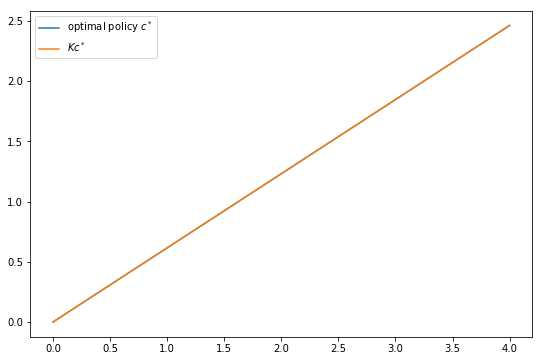

In [7]:
c_star_new = coleman_egm(c_star,
            k_grid, beta, u_prime, u_prime, f, f_prime, shocks)

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(k_grid, c_star(k_grid), label="optimal policy $c^*$")
ax.plot(k_grid, c_star_new(k_grid), label="$Kc^*$")

ax.legend(loc='upper left')
plt.show()

Notice that we're passing `u_prime` to `coleman_egm` twice

The reason is that, in the case of log utility, $ u'(c) = (u')^{-1}(c) = 1/c $

Hence `u_prime` and `u_prime_inv` are the same

We can't really distinguish the two plots

In fact it's easy to see that the difference is essentially zero:

In [8]:
max(abs(c_star_new(k_grid) - c_star(k_grid)))

9.8816666666666723e-06

Next let's try iterating from an arbitrary initial condition and see if we
converge towards $ c^* $

Let's start from the consumption policy that eats the whole pie: $ c(y) = y $

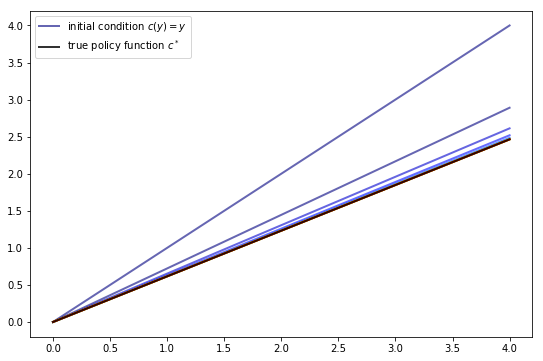

In [9]:
g = lambda x: x
n = 15
fig, ax = plt.subplots(figsize=(9, 6))
lb = 'initial condition $c(y) = y$'

ax.plot(k_grid, g(k_grid), color=plt.cm.jet(0), lw=2, alpha=0.6, label=lb)

for i in range(n):
    new_g = coleman_egm(g, k_grid, beta, u_prime, u_prime, f, f_prime, shocks)
    g = new_g
    ax.plot(k_grid, g(k_grid), color=plt.cm.jet(i / n), lw=2, alpha=0.6)

lb = 'true policy function $c^*$'
ax.plot(k_grid, c_star(k_grid), 'k-', lw=2, alpha=0.8, label=lb)
ax.legend(loc='upper left')

plt.show()

We see that the policy has converged nicely, in only a few steps

## Speed

Now let's compare the clock times per iteration for the standard Coleman
operator (with exogenous grid) and the EGM version

We'll do so using the CRRA model adopted in the exercises of the [Coleman
policy iteration lecture](https://lectures.quantecon.org/py/coleman_policy_iter.html)

Here's the model and some convenient functions

In [10]:
## Define the model

alpha = 0.65
beta = 0.95
mu = 0
s = 0.1
grid_min = 1e-6
grid_max = 4
grid_size = 200
shock_size = 250

gamma = 1.5   # Preference parameter
gamma_inv = 1 / gamma

def f(k):
    return k**alpha

def f_prime(k):
    return alpha * k**(alpha - 1)

def u(c):
    return (c**(1 - gamma) - 1) / (1 - gamma)

def u_prime(c):
    return c**(-gamma)

def u_prime_inv(c):
    return c**(-gamma_inv)

k_grid = np.linspace(grid_min, grid_max, grid_size)
shocks = np.exp(mu + s * np.random.randn(shock_size))

## Let's make convenience functions based around these primitives

def crra_coleman(g):
    return coleman_operator(g, k_grid, beta, u_prime, f, f_prime, shocks)

def crra_coleman_egm(g):
    return coleman_egm(g, k_grid, beta, u_prime, u_prime_inv, f, f_prime, shocks)

Here's the result

In [11]:
from scipy.optimize import brentq

## Iterate, compare policies

sim_length = 20

print("Timing standard Coleman policy function iteration")
g_init = k_grid
g = g_init
qe.util.tic()
for i in range(sim_length):
    new_g = crra_coleman(g)
    g = new_g
qe.util.toc()


print("Timing policy function iteration with endogenous grid")
g_init_egm = lambda x: x
g = g_init_egm
qe.util.tic()
for i in range(sim_length):
    new_g = crra_coleman_egm(g)
    g = new_g
qe.util.toc()

Timing standard Coleman policy function iteration
TOC: Elapsed: 1.8903779983520508 seconds.
Timing policy function iteration with endogenous grid
TOC: Elapsed: 0.14305877685546875 seconds.


0.14305877685546875

We see that the EGM version is more than 6 times faster

At the same time, the absence of numerical root finding means that it is
typically more accurate at each step as well